In [ ]:
!pip install --upgrade gensim==3.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2023-04-14 02:32:49--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-04-14 02:32:49--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  34.6MB/s    in 0.4s    

2023-04-14 02:32:50 (34.6 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.18" 2023-01-17
OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1)
OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)


In [ ]:
# upload male and female corpora

import zipfile
from google.colab import files

uploaded = files.upload()

In [ ]:
uploaded = files.upload()

path_to_zip_file = list(uploaded.keys())[0]

print ('Extracting',path_to_zip_file)

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall('.')

print()
print('Here is a directory listing (you should see a directory with your corpus):')
!ls -l

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
female_corpus_path = 'female'
male_corpus_path = 'male'

In [ ]:
def load_data_from_dir(path):
    file_list = glob.glob(path + '/*.txt')

    # create document list:
    documents_list = []
    source_list = []
    for filename in file_list:
        with open(filename, 'r', encoding='utf8') as f:
            text = f.read()
            f.close()
            documents_list.append(text)
            source_list.append(os.path.basename(filename))
    print("Total Number of Documents:",len(documents_list))
    return documents_list, source_list

def preprocess_data(doc_set,extra_stopwords = {}):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # replace all newlines or multiple sequences of spaces with a standard space
    doc_set = [re.sub('\s+', ' ', doc) for doc in doc_set]
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # add any extra stopwords
    if (len(extra_stopwords) > 0):
        en_stop = en_stop.union(extra_stopwords)
    
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

def prepare_corpus(doc_clean):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
# adjust the path below to wherever you have the transcripts2018 folder
female_document_list, female_source_list = load_data_from_dir('female')
male_document_list, male_source_list = load_data_from_dir('male')

# I've added extra stopwords here in addition to NLTK's stopword list - you could look at adding others.
female_doc_clean = preprocess_data(female_document_list, {'would', 'could', 'wouldnt', 'couldnt'})
male_doc_clean = preprocess_data(male_document_list, {'would', 'could', 'wouldnt', 'couldnt'})
female_dictionary, female_doc_term_matrix = prepare_corpus(female_doc_clean)
male_dictionary, male_doc_term_matrix = prepare_corpus(male_doc_clean)

Total Number of Documents: 237
Total Number of Documents: 214


In [ ]:
number_of_topics=30 # adjust this to alter the number of topics
words=20 #adjust this to alter the number of words output for the topic below

In [ ]:
female_ldamallet30 = LdaMallet(mallet_path, corpus=female_doc_term_matrix, num_topics=number_of_topics, id2word=female_dictionary)
male_ldamallet30 = LdaMallet(mallet_path, corpus=male_doc_term_matrix, num_topics=number_of_topics, id2word=male_dictionary)

In [ ]:
uploaded = files.upload()

Saving results.zip to results.zip


In [ ]:
path_to_zip_file = list(uploaded.keys())[0]

print ('Extracting',path_to_zip_file)

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall('.')

print()
print('Here is a directory listing (you should see a directory with your corpus):')
!ls -l

Extracting results.zip

Here is a directory listing (you should see a directory with your corpus):
total 232576
drwx------  6 root root      4096 Apr 14 02:19 gdrive
drwxr-xr-x 10 root root      4096 Nov 14  2016 mallet-2.0.8
-rw-r--r--  1 root root  16184794 Nov 14  2016 mallet-2.0.8.zip
drwxr-xr-x  4 root root      4096 Apr 14 03:05 results
-rw-r--r--  1 root root 221952938 Apr 14 02:59 results.zip
drwxr-xr-x  1 root root      4096 Apr 12 13:34 sample_data


In [ ]:
path_to_topic_distributions_female = f"results/female/mallet.topic_distributions.{str(15)}"
path_to_topic_distributions_male = f"results/female/mallet.topic_distributions.{str(15)}"


In [ ]:
!pip install little_mallet_wrapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path

In [ ]:
topic_distributions_female = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions_female)
topic_distributions_male = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions_male)

In [ ]:
topic_distributions_female[32]


[0.40069753257496293,
 0.01253972931953474,
 0.12901595306445524,
 0.0033739370574246232,
 1.12063421673522e-06,
 0.10369022450090983,
 7.867271318692468e-07,
 7.39250161045393e-07,
 6.868530570720625e-07,
 1.0244190483234911e-06,
 0.011630583132504963,
 0.018478414364312405,
 0.146528874360963,
 0.16762014893092164,
 0.006420244810395567]

In [ ]:
uploaded = files.upload()

Saving female.zip to female.zip


In [ ]:
path_to_zip_file = list(uploaded.keys())[0]

print ('Extracting',path_to_zip_file)

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall('.')

print()
print('Here is a directory listing (you should see a directory with your corpus):')
!ls -l

Extracting female.zip

Here is a directory listing (you should see a directory with your corpus):
total 297996
drwxr-xr-x  2 root root     20480 Apr 14 03:43 female
-rw-r--r--  1 root root  66961720 Apr 14 03:43 female.zip
drwx------  6 root root      4096 Apr 14 02:19 gdrive
drwxr-xr-x 10 root root      4096 Nov 14  2016 mallet-2.0.8
-rw-r--r--  1 root root  16184794 Nov 14  2016 mallet-2.0.8.zip
drwxr-xr-x  4 root root      4096 Apr 14 03:05 results
-rw-r--r--  1 root root 221952938 Apr 14 02:59 results.zip
drwxr-xr-x  1 root root      4096 Apr 12 13:34 sample_data


In [ ]:
uploaded = files.upload()

Saving male.zip to male.zip


In [ ]:
path_to_zip_file = list(uploaded.keys())[0]

print ('Extracting',path_to_zip_file)

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall('.')

print()
print('Here is a directory listing (you should see a directory with your corpus):')
!ls -l

Extracting male.zip

Here is a directory listing (you should see a directory with your corpus):
total 358004
drwxr-xr-x  2 root root     20480 Apr 14 03:43 female
-rw-r--r--  1 root root  66961720 Apr 14 03:43 female.zip
drwx------  6 root root      4096 Apr 14 02:19 gdrive
drwxr-xr-x  2 root root     20480 Apr 14 03:49 male
-rw-r--r--  1 root root  61426968 Apr 14 03:48 male.zip
drwxr-xr-x 10 root root      4096 Nov 14  2016 mallet-2.0.8
-rw-r--r--  1 root root  16184794 Nov 14  2016 mallet-2.0.8.zip
drwxr-xr-x  4 root root      4096 Apr 14 03:05 results
-rw-r--r--  1 root root 221952938 Apr 14 02:59 results.zip
drwxr-xr-x  1 root root      4096 Apr 12 13:34 sample_data


In [ ]:
directory_female = "female"
files = glob.glob(f"{directory_female}/*.txt")
path_to_topic_keys_female = f"results/female/mallet.topic_keys.{str(15)}"

novel_titles_female = [Path(file).stem for file in files]
novel_to_check_female = "AlexanderMrs__Monaschoiceanovel"
novel_number_female = novel_titles_female.index(novel_to_check_female)
topics_female = little_mallet_wrapper.load_topic_keys(path_to_topic_keys_female)


# print(f"Topic Distributions for {novel_titles_female[novel_number_female]}\n")
# for topic_number, (topic, topic_distribution) in enumerate(zip(topics_female, topic_distributions_female[novel_number_female])):
#     print(f"✨Topic {topic_number} {topic[:6]} ✨\nProbability: {round(topic_distribution, 3)}\n")

In [ ]:
import random
target_labels = random.sample(novel_titles_female, 14)

/usr/local/lib/python3.9/dist-packages/little_mallet_wrapper/little_mallet_wrapper.py:230: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


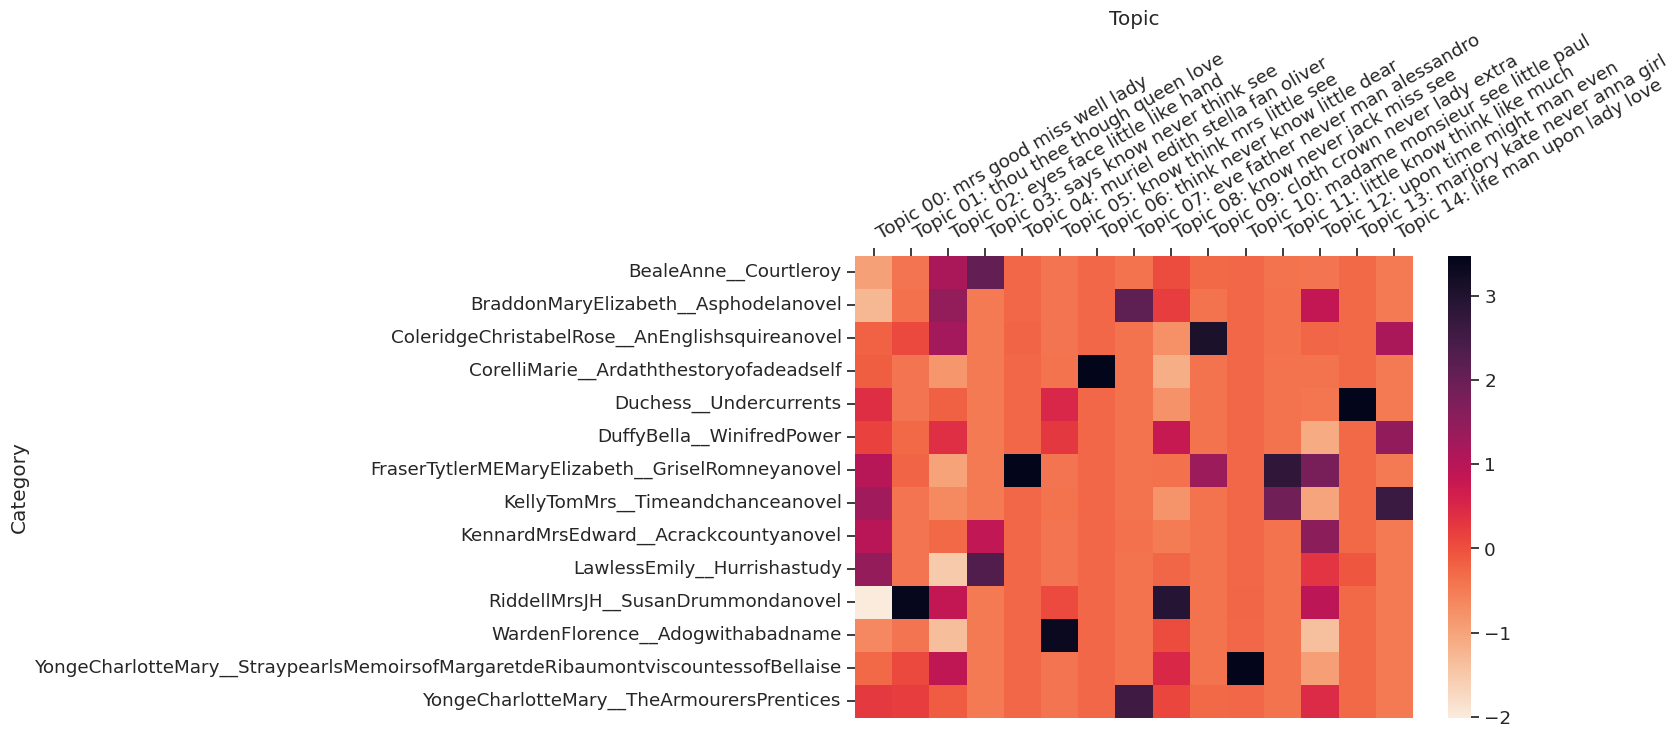

In [ ]:
output_directory_path = 'results'
little_mallet_wrapper.plot_categories_by_topics_heatmap(novel_titles_female,
                                      topic_distributions_female,
                                      topics_female,
                                      None,
                                      target_labels=target_labels,
                                      dim=(9,6)
                                     )

In [ ]:
files = glob.glob(f"male/*.txt")
path_to_topic_keys_male = f"results/male/mallet.topic_keys.{str(15)}"

novel_titles_male = [Path(file).stem for file in files]
topics_male = little_mallet_wrapper.load_topic_keys(path_to_topic_keys_male)

import random
target_labels_male = random.sample(novel_titles_male, 14)

/usr/local/lib/python3.9/dist-packages/little_mallet_wrapper/little_mallet_wrapper.py:230: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


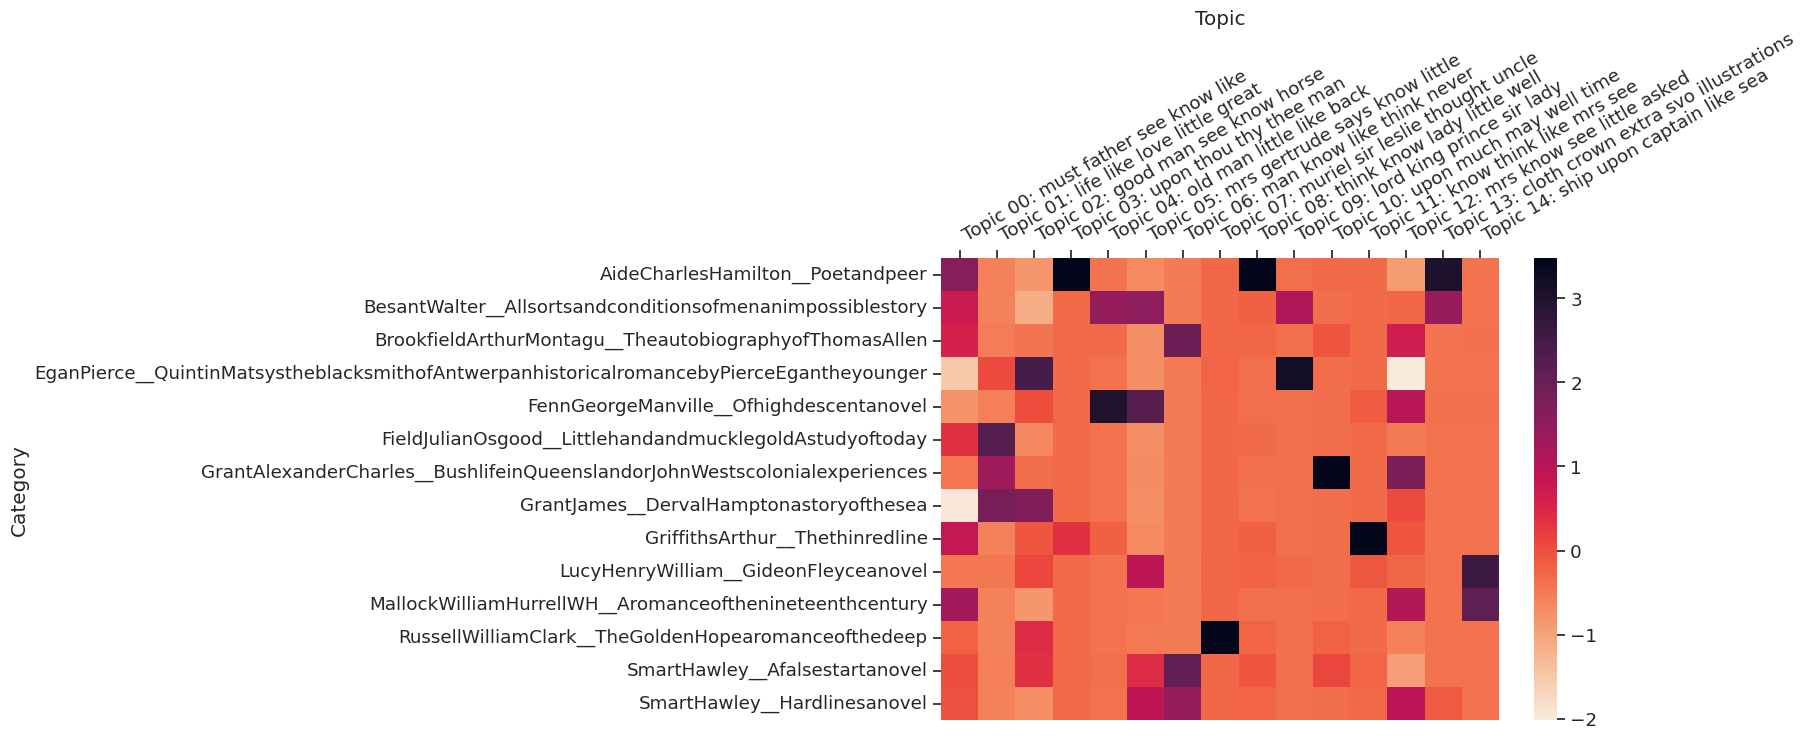

In [ ]:
output_directory_path = 'results'
little_mallet_wrapper.plot_categories_by_topics_heatmap(novel_titles_male,
                                      topic_distributions_male,
                                      topics_male,
                                      output_directory_path + '/categories_by_topics_male.jpg',
                                      target_labels=target_labels_male,
                                      dim=(9,6)
                                     )

In [ ]:
for topic_number, topic in enumerate(topics_female):
    print(f"Topic {topic_number}: {topic[:6]}")

Topic 0: ['mrs', 'good', 'miss', 'well', 'lady', 'little']
Topic 1: ['thou', 'thee', 'though', 'queen', 'love', 'thy']
Topic 2: ['eyes', 'face', 'little', 'like', 'hand', 'man']
Topic 3: ['says', 'know', 'never', 'think', 'see', 'shall']
Topic 4: ['muriel', 'edith', 'stella', 'fan', 'oliver', 'mrs']
Topic 5: ['know', 'think', 'mrs', 'little', 'see', 'never']
Topic 6: ['think', 'never', 'know', 'little', 'dear', 'quite']
Topic 7: ['eve', 'father', 'never', 'man', 'alessandro', 'see']
Topic 8: ['know', 'never', 'jack', 'miss', 'see', 'much']
Topic 9: ['cloth', 'crown', 'never', 'lady', 'extra', 'life']
Topic 10: ['madame', 'monsieur', 'see', 'little', 'paul', 'thought']
Topic 11: ['little', 'know', 'think', 'like', 'much', 'lucy']
Topic 12: ['upon', 'time', 'might', 'man', 'even', 'however']
Topic 13: ['marjory', 'kate', 'never', 'anna', 'girl', 'jessie']
Topic 14: ['life', 'man', 'upon', 'lady', 'love', 'old']


In [ ]:
for topic_number, topic in enumerate(topics_male):
    print(f"Topic {topic_number}: {topic[:6]}")

Topic 0: ['must', 'father', 'see', 'know', 'like', 'put']
Topic 1: ['life', 'like', 'love', 'little', 'great', 'eyes']
Topic 2: ['good', 'man', 'see', 'know', 'horse', 'little']
Topic 3: ['upon', 'thou', 'thy', 'thee', 'man', 'horn']
Topic 4: ['old', 'man', 'little', 'like', 'back', 'see']
Topic 5: ['mrs', 'gertrude', 'says', 'know', 'little', 'see']
Topic 6: ['man', 'know', 'like', 'think', 'never', 'good']
Topic 7: ['muriel', 'sir', 'leslie', 'thought', 'uncle', 'girl']
Topic 8: ['think', 'know', 'lady', 'little', 'well', 'see']
Topic 9: ['lord', 'king', 'prince', 'sir', 'lady', 'upon']
Topic 10: ['upon', 'much', 'may', 'well', 'time', 'might']
Topic 11: ['know', 'think', 'like', 'mrs', 'see', 'thought']
Topic 12: ['mrs', 'know', 'see', 'little', 'asked', 'room']
Topic 13: ['cloth', 'crown', 'extra', 'svo', 'illustrations', 'post']
Topic 14: ['ship', 'upon', 'captain', 'like', 'sea', 'water']


In [ ]:
path_to_topic_distributions_female_new = f"results/female/mallet.topic_distributions.{str(5)}"
path_to_topic_distributions_male_new = f"results/female/mallet.topic_distributions.{str(5)}"

In [ ]:
topic_distributions_female_new = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions_female_new)
topic_distributions_male_new = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions_male_new)

In [ ]:
files = glob.glob(f"female/*.txt")
path_to_topic_keys_female_new = f"results/female/mallet.topic_keys.{str(5)}"
novel_titles_female_new = [Path(file).stem for file in files]
topics_female_new = little_mallet_wrapper.load_topic_keys(path_to_topic_keys_female_new)
for topic_number, topic in enumerate(topics_female_new):
    print(f"Topic {topic_number}: {topic[:6]}")

Topic 0: ['little', 'know', 'think', 'like', 'much', 'never']
Topic 1: ['life', 'never', 'lady', 'like', 'little', 'cloth']
Topic 2: ['mrs', 'miss', 'never', 'well', 'much', 'know']
Topic 3: ['know', 'little', 'think', 'mrs', 'see', 'never']
Topic 4: ['little', 'like', 'man', 'eyes', 'face', 'upon']


In [ ]:
import random
target_labels_female_new = random.sample(novel_titles_female, 5)

/usr/local/lib/python3.9/dist-packages/little_mallet_wrapper/little_mallet_wrapper.py:230: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


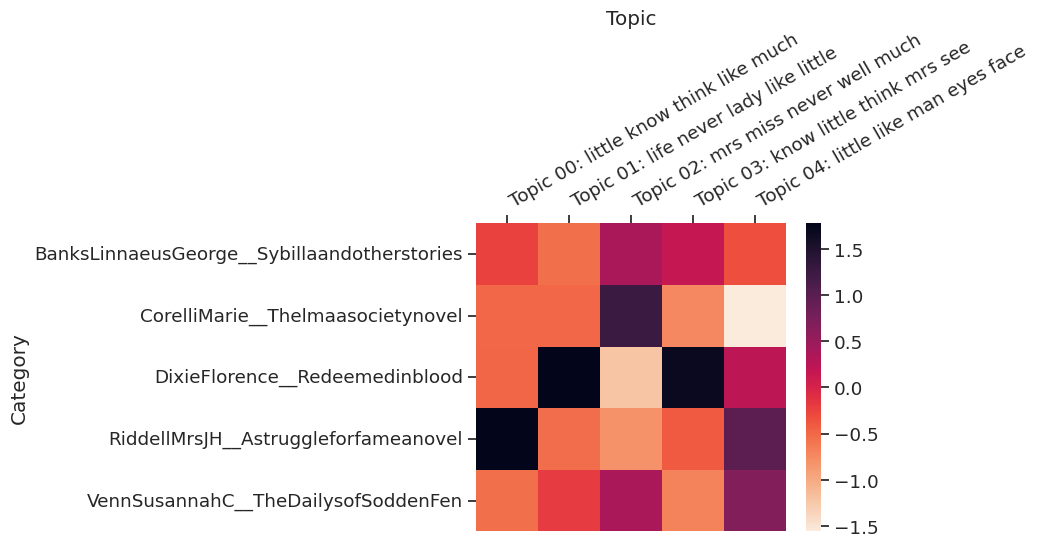

In [ ]:
output_directory_path = 'results'
little_mallet_wrapper.plot_categories_by_topics_heatmap(novel_titles_female_new,
                                      topic_distributions_female_new,
                                      topics_female_new,
                                      None,
                                      target_labels=target_labels_female_new,
                                      dim=(5,4)
                                     )

In [ ]:
files = glob.glob(f"male/*.txt")
path_to_topic_keys_male_new = f"results/male/mallet.topic_keys.{str(5)}"
novel_titles_male_new = [Path(file).stem for file in files]
topics_male_new = little_mallet_wrapper.load_topic_keys(path_to_topic_keys_male_new)
for topic_number, topic in enumerate(topics_male_new):
    print(f"Topic {topic_number}: {topic[:6]}")

Topic 0: ['like', 'man', 'upon', 'captain', 'sea', 'came']
Topic 1: ['upon', 'man', 'cloth', 'crown', 'like', 'extra']
Topic 2: ['know', 'think', 'time', 'well', 'little', 'much']
Topic 3: ['sir', 'well', 'man', 'good', 'old', 'upon']
Topic 4: ['man', 'old', 'little', 'see', 'like', 'come']


In [ ]:
target_labels_male_new = random.sample(novel_titles_male, 5)

/usr/local/lib/python3.9/dist-packages/little_mallet_wrapper/little_mallet_wrapper.py:230: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


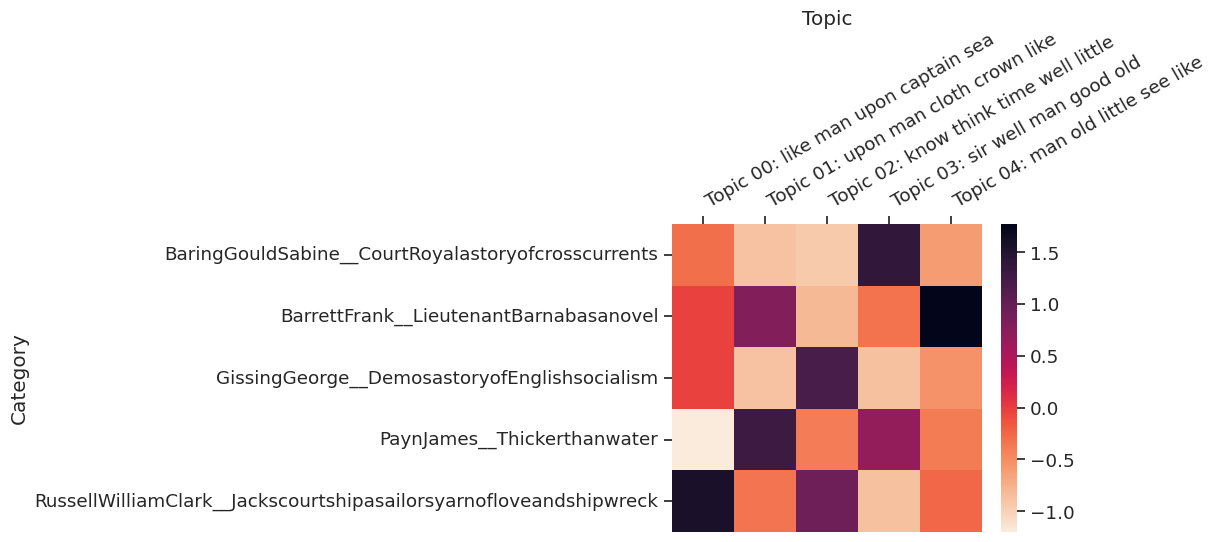

In [ ]:
output_directory_path = 'results'
little_mallet_wrapper.plot_categories_by_topics_heatmap(novel_titles_male_new,
                                      topic_distributions_male_new,
                                      topics_male_new,
                                      None,
                                      target_labels=target_labels_male_new,
                                      dim=(5,4)
                                     )